<a href="https://colab.research.google.com/github/adolfolh/casualty-classification/blob/main/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **`3` | MODELLING** 📈

In [ ]:
# Run to download data
!wget https://github.com/adolfolh/casuality-classification/raw/main/data/X_train.csv
!wget https://github.com/adolfolh/casuality-classification/raw/main/data/y_train.csv
!wget https://github.com/adolfolh/casuality-classification/raw/main/data/X_test.csv
!wget https://github.com/adolfolh/casuality-classification/raw/main/data/y_test.csv

In [22]:
# Import libraries
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import plotly.graph_objects as go
import time

In [73]:
'''
Helper Functions
'''

def modelMetrics(y_test, y_pred, model):
  print(f"Model Performance Evaluation for {model}.\n")
  print("\t- Accuracy:",metrics.accuracy_score(y_test, y_pred))
  macro_averaged_precision = metrics.precision_score(y_test, y_pred, average = 'macro')
  print(f"\t- Macro-Averaged Precision score: {macro_averaged_precision}")
  micro_averaged_precision = metrics.precision_score(y_test, y_pred, average = 'micro')
  print(f"\t- Micro-Averaged Precision score: {micro_averaged_precision}")
  macro_averaged_recall = metrics.recall_score(y_test, y_pred, average = 'macro')
  print(f"\t- Macro-averaged recall score: {macro_averaged_recall}")
  micro_averaged_recall = metrics.recall_score(y_test, y_pred, average = 'micro')
  print(f"\t- Micro-Averaged recall score: {micro_averaged_recall}")
  macro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'macro')
  print(f"\t- Macro-Averaged F1 score: {macro_averaged_f1}")
  micro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'micro')
  print(f"\t- Micro-Averaged F1 score: {micro_averaged_f1}")

  print(f"\n\n{model}'s Confusion Matrix:\n")
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(1,2, figsize=(20, 8))
  sns.heatmap(cm, 
              annot = True, 
              cmap = 'summer',
              ax=ax[0])
  ax[0].set_title(f"{model}'s Confusion Matrix:\n", fontsize=14)
  ax[0].set_xlabel('Predicted Labels')
  ax[0].set_ylabel('True Labels')

  sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 
              annot = True, 
              cmap = 'summer',
              vmin = 0,
              vmax = 1,
              ax=ax[1])
  ax[1].set_title(f"{model}'s Percentage Confusion Matrix:\n", fontsize=14)
  ax[1].set_xlabel('Predicted Labels')
  ax[1].set_ylabel('True Labels')
  plt.show()

def modelPred(model, X_train, y_train, X_test, y_test):
    y_train = pd.Series(y_train)
    y_test = pd.Series(y_test)   
    fitted_model = model.fit(X_train,y_train)

    pred_prob = pd.DataFrame(fitted_model.predict_proba(X_test))
    pred = pd.DataFrame(fitted_model.predict(X_test))
    pred = pd.concat([y_test,pred_prob,pred],axis=1, ignore_index=True)
    pred.columns = ['Actual','y_prob (1)', 'y_prob (2)','y_prob (3)', 'y_pred']
    return(pred)

# eval_id (T/F): [CV,Train,Test,all]
def modelEval(X_train, y_train, y_test, X_test, eval_id=[True,True,True,True],
              n_fold=5,scoring='accuracy',plot_id=True,cv_yrange=None,hm_vvals=[0.5,1.0,0.75]):
      
    X_one = pd.concat([X_train,X_test],axis=0)
    y_one = pd.concat([pd.Series(y_train),pd.Series(y_test)],axis=0)
    
    ''' Cross Validation, Training/Evaluation, one evaluation'''
    lst_res = []; names = []; lst_train = []; lst_eval = []; lst_one = []; lst_res_mean = []
    if(any(eval_id)):
        for name, model in models:  # cycle through models & evaluate either cv or train/test
            names.append(name)
            
            # Cross Validation Model on Training Set
            if(eval_id[0]):
                t0=time.time()
                kfold = KFold(n_splits=n_fold)
                cv_res = cross_val_score(model,X_train,y_train, cv=kfold, scoring=scoring)
                t1 = time.time()
                lst_res.append(cv_res)
                tt1 = t1-t0 # total time for n_fold cross evaluation
                
            # Evaluate Fit Model on Training Data
            t2 = time.time()
            if(eval_id[1]):
                t2 = time.time()
                res = model.fit(X_train,y_train)
                train_res = accuracy_score(res.predict(X_train),y_train) 
                lst_train.append(train_res)
            if(eval_id[2]):
                if(eval_id[1] is False):  # If training hasn't been called yet
                    res = model.fit(X_train,y_train)
                eval_res = accuracy_score(res.predict(X_test),y_test) 
                lst_eval.append(eval_res)
            t3 = time.time()
            tt2 = t3-t2 # total time for training/evaluation train/prediction
            
            # Evaluate model on entire dataset
            if(eval_id[3]):
                t4 = time.time()
                res = model.fit(X_one,y_one)
                one_res = accuracy_score(res.predict(X_one),y_one); lst_one.append(one_res)
                t5 = time.time()
                tt3 = t5-t4 # total time for training & evaluation on whole dataframe
            
            ''' [out] Verbal Outputs '''
            # Cross Validation / Training / Evaluation Model Evaluation / Section Times
            lst_res_mean.append(cv_res.mean())
            fn1 = cv_res.mean(); fn2 = cv_res.std();
            fn3 = train_res; fn4 = eval_res; fn5 = one_res
            print(f"{name} : {fn1:.3f}({fn2:.3f}) -> {tt1:.2f}s | {fn3:.3f} & {fn4:.3f} -> {tt2:.2f}s | {fn5:.3f} -> {tt3:.2}s")
      
    s0 = pd.Series(np.array(lst_res_mean),index=names)
    s1 = pd.Series(np.array(lst_train),index=names)
    s2 = pd.Series(np.array(lst_eval),index=names)
    s3 = pd.Series(np.array(lst_one),index=names)
    pdf = pd.concat([s0,s1,s2,s3],axis=1)
    pdf.columns = ['cv_average','train','test','all']
    s4 = pd.Series([tt1,tt2,tt3],index=['cv','train/test','all'])
        
    ''' Visual Ouputs '''
    if(plot_id): 
        
        sns.set(style="whitegrid")
        fig,ax = plt.subplots(1,2,figsize=(15,4))
        ax[0].set_title(f'{n_fold} Cross Validation Results')
        sns.boxplot(data=lst_res, ax=ax[0], orient="v",width=0.3)
        ax[0].set_xticklabels(names)
        sns.stripplot(data=lst_res,ax=ax[0], orient='v',color=".3",linewidth=1)
        ax[0].set_xticklabels(names)
        ax[0].xaxis.grid(True)
        ax[0].set(xlabel="")
        if(cv_yrange is not None):
            ax[0].set_ylim(cv_yrange)
        sns.despine(trim=True, left=True)
    
        sns.heatmap(pdf,vmin=hm_vvals[0],vmax=hm_vvals[1],center=hm_vvals[2],
                    ax=ax[1],square=False,lw=2,annot=True,fmt='.3f',cmap='Blues')
        ax[1].set_title('Accuracy Scores')
        plt.show()

In [24]:
# Import data
X_train = pd.read_csv(r'X_train.csv')
X_train.drop(['Unnamed: 0'], axis=1, inplace=True)
y_train = pd.read_csv(r'y_train.csv')
y_train.drop(['Unnamed: 0'], axis=1, inplace=True)
X_test = pd.read_csv(r'X_test.csv')
X_test.drop(['Unnamed: 0'], axis=1, inplace=True)
y_test = pd.read_csv(r'y_test.csv')
y_test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [25]:
print(f"Shape of training features: {X_train.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of testing features: {X_test.shape}")
print(f"Shape of testing labels: {y_test.shape}")

Shape of training features: (78634, 11)
Shape of training labels: (78634, 1)
Shape of testing features: (19659, 11)
Shape of testing labels: (19659, 1)


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier

models = []

# Lightweight Models 
models.append(('LDA', LinearDiscriminantAnalysis()))  # Unsupervised Model 
models.append(('KNN', KNeighborsClassifier()))  # Unsupervised Model
models.append(('TREE', DecisionTreeClassifier())) # Supervised Model
models.append(('NB', GaussianNB())) # Unsupervised Model

# More Advanced Models
models.append(('GBM', GradientBoostingClassifier(n_estimators=25)))
models.append(('RF', RandomForestClassifier(n_estimators=25)))
models.append(('GMM', GaussianMixture(n_components=4, random_state=1,max_iter=100)))
models.append(('NN', MLPClassifier(random_state=1, max_iter=300)))

In [77]:
# @title Run Model Overview?
overview = False #@param ["True", "False"] {type:"raw"}

LDA : 0.817(0.003) -> 1.63s | 0.817 & 0.814 -> 0.57s | 0.816 -> 0.77s
KNN : 0.791(0.003) -> 10.97s | 0.826 & 0.787 -> 7.40s | 0.825 -> 8.0s
TREE : 0.760(0.003) -> 0.77s | 0.873 & 0.762 -> 0.22s | 0.868 -> 0.26s
NB : 0.630(0.297) -> 0.17s | 0.778 & 0.776 -> 0.07s | 0.778 -> 0.067s
GBM : 0.818(0.003) -> 21.03s | 0.818 & 0.816 -> 5.29s | 0.818 -> 6.6s
RF : 0.785(0.004) -> 6.79s | 0.872 & 0.786 -> 2.29s | 0.867 -> 2.7s
GMM : 0.167(0.058) -> 9.61s | 0.130 & 0.132 -> 2.26s | 0.118 -> 2.6s
NN : 0.817(0.002) -> 148.67s | 0.815 & 0.811 -> 21.51s | 0.817 -> 6e+01s


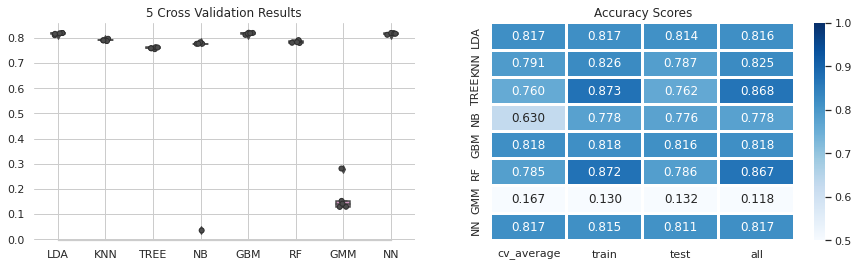

In [78]:
if overview == True:
  modelEval(X_train, y_train.values.ravel(), y_test.values.ravel(), X_test)

Model Performance Evaluation for Decision Tree Classifier.

	- Accuracy: 0.761381555521644
	- Macro-Averaged Precision score: 0.38592169776252305
	- Micro-Averaged Precision score: 0.761381555521644
	- Macro-averaged recall score: 0.37221195535203816
	- Micro-Averaged recall score: 0.761381555521644
	- Macro-Averaged F1 score: 0.37536934951767725
	- Micro-Averaged F1 score: 0.761381555521644


Decision Tree Classifier's Confusion Matrix:



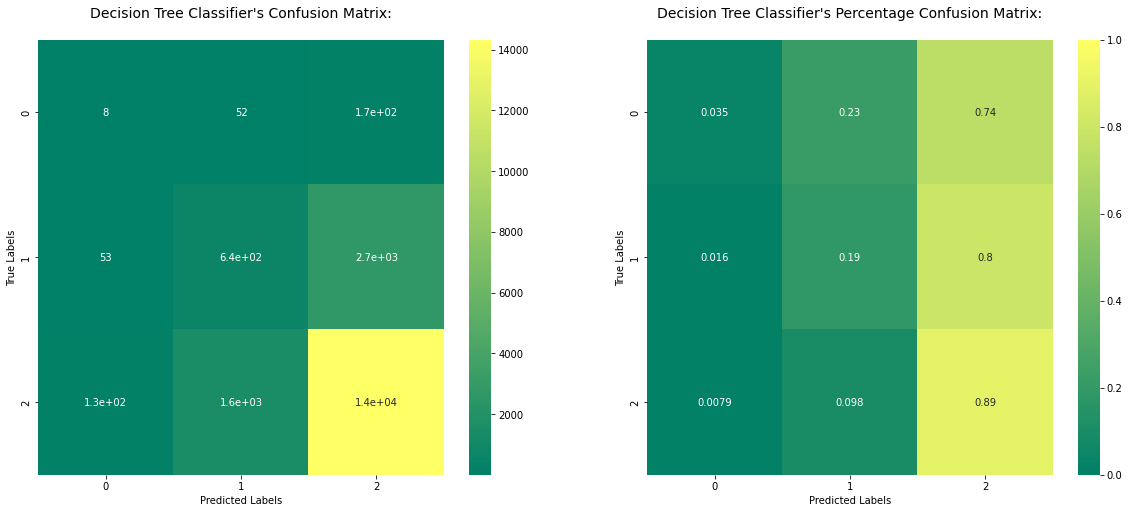

In [74]:
# Decision Tree Modeling
dt_model = DecisionTreeClassifier(random_state=0)
dt_pred = modelPred(dt_model, X_train, y_train.values.ravel(), X_test, y_test.values.ravel())
modelMetrics(dt_pred['Actual'], dt_pred['y_pred'], 'Decision Tree Classifier')

Model Performance Evaluation for Neural Network Classifier.

	- Accuracy: 0.8111297624497685
	- Macro-Averaged Precision score: 0.40953495391000283
	- Micro-Averaged Precision score: 0.8111297624497685
	- Macro-averaged recall score: 0.3479098632527608
	- Micro-Averaged recall score: 0.8111297624497685
	- Macro-Averaged F1 score: 0.333861800907427
	- Micro-Averaged F1 score: 0.8111297624497685


Neural Network Classifier's Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


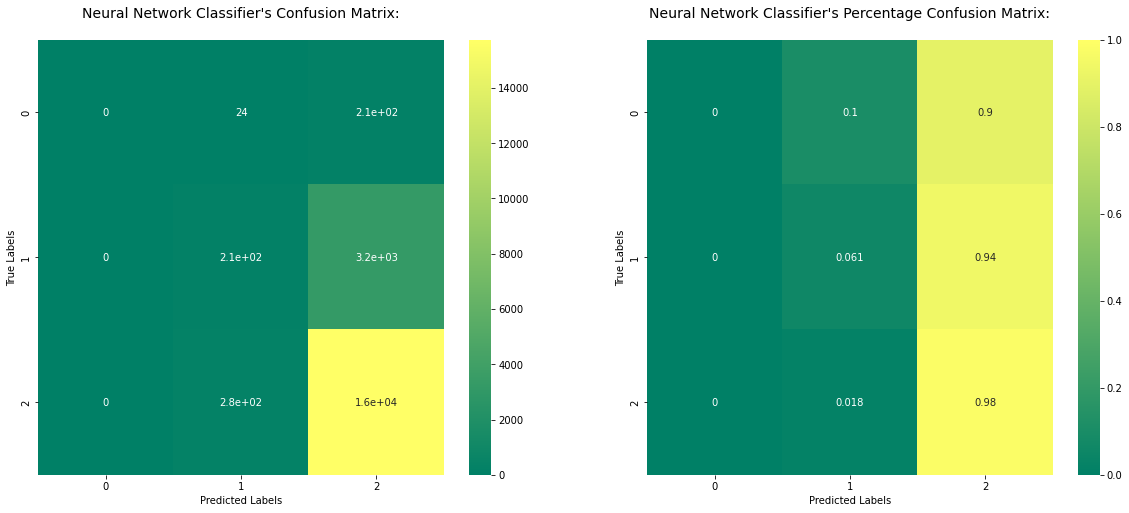

In [75]:
# Neural Network Modeling
nn_model = MLPClassifier(random_state=1, max_iter=300)
nn_pred = modelPred(nn_model, X_train, y_train.values.ravel(), X_test, y_test.values.ravel())
modelMetrics(nn_pred['Actual'], nn_pred['y_pred'], 'Neural Network Classifier')